In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('data/all_data.csv')
data_by_genres = pd.read_csv('data/data_by_genres.csv')
data_by_years = pd.read_csv('data/data_by_years.csv')

### Visualize the sound features over the years

In [ ]:
import plotly.express as px
    
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(data_frame = data_by_years, x = "year", y = sound_features, markers = False)
fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def show_plotly_graph_objects(data):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = data['year'], y = data['acousticness'], name = 'Acousticness'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['valence'], name = 'Valence'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['danceability'], name = 'Danceability'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['energy'], name = 'Energy'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['instrumentalness'], name = 'Instrumentalness'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['liveness'], name = 'Liveness'))
    fig.add_trace(go.Scatter(x = data['year'], y = data['speechiness'], name = 'Speechiness'))
    fig = px.imshow(data.corr(), text_auto=True)
    fig.show()

show_plotly_graph_objects(data_by_years)

### Data Preprocessing

In [ ]:
from functions.utils import preprocess_data, preprocess_data_by_genres, preprocess_data_by_years

data_processed = preprocess_data('data/all_data.csv')
data_by_genres_processed = preprocess_data_by_genres('data/data_by_genres.csv')
data_by_years_processed = preprocess_data_by_years('data/data_by_years.csv')

# Data Clustering

### Cluster the data with the KMeans algorithm

In [ ]:
import numpy as np
from sklearn.cluster import KMeans


SEED = 42
np.random.seed(SEED)
  

def cluster_with_kmeans(data, projection, n_clusters=5):
    """
    Cluster data using K-Means on PCA-projected data.

    Parameters:
    - data (DataFrame): The input data.
    - projection (DataFrame): DataFrame with PCA projection.
    - n_cluster: The number of clusters to form as well as the number of centroids to generate.

    Returns:
    - data (DataFrame): Original data with cluster labels.
    - projection (DataFrame): PCA projection with cluster labels.
    """
    try:
        # Unsupervised method
        kmeans = KMeans(n_clusters=n_clusters, verbose=False, random_state=SEED, n_init=10)
        kmeans.fit_transform(projection)
        data['cluster_pca'] = kmeans.predict(projection)
        projection['cluster_pca'] = kmeans.predict(projection)
        return data, projection

    except Exception as e:
        print(f"An error occurred during clustering with k_means: {e}")
        return None, None


###  Preprocessing and Clustering Music Genre Data

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_genre_data(data):
    """
    Preprocess the data and apply PCA for dimensionality reduction.

    Parameters:
    - data (DataFrame): The input data.
    - n_components: Int | float | str | None

    Returns:
    - projection (DataFrame): DataFrame with PCA projection.
    - components (int): Number of principal components retained.
    - var_exp (float): Total explained variance by the retained components.
    """
    try:
        # Create a pipeline with two steps: standardization and dimensionality reduction (PCA)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),   # Standardization step
            ('PCA', PCA(n_components=2, random_state= SEED))   # PCA step with 2 principal components 
        ])

        genre_embedding_pca = pipeline.fit_transform(data)
        projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding_pca)
        components = pipeline[1].n_components_ 
        var_exp  = pipeline[1].explained_variance_ratio_.sum()
        return projection, components, var_exp 

    except Exception as e:
        print(f"An error occurred during preprocess genre data: {e}")
        return None, None, None
    
def clustering_genre_projection(data):
    try:
        # Step 1: Remove genres from 'data_by_genres'
        data_v1 = data.drop('genres', axis = 1)

        # Step 2: Preprocess the data and apply PCA for dimensionality reduction
        projection, components, var_exp = preprocess_genre_data(data_v1)
        
        # Step 3: Cluster data using K-Means on PCA-projected data
        _, projection = cluster_with_kmeans(data_v1, projection)
        
        # Step 4: Add 'genres' column to the projection DataFrame
        projection['genres'] = data['genres']
        projection_shape = projection.shape
        return projection, components, var_exp, projection_shape
    
    except Exception as e:
        print(f"An error occurred during genre clustering projection: {e}")
        return None, None, None, None


projection, components, var_exp, projection_shape= clustering_genre_projection(data_by_genres_processed)
print(f"\nGenre Data: \nComponents = {components} \nTotal explained variance = {round(var_exp * 100,3)}%")

fig = px.scatter(projection,  x='x', y='y', color = 'cluster_pca', hover_data=['x', 'y', 'genres'])
fig.show()  


Genre Data: 
Components = 2 
Total explained variance = 49.271%


### Preprocessing and Clustering All Music Data

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def preprocess_music_data(data,column):
    try:
        ohe = OneHotEncoder(dtype=int)
        ohe_columns = ohe.fit_transform(data[[column]]).toarray()
        data = data.drop(column, axis=1)
    
        data_dummies_music = pd.concat([data, pd.DataFrame(ohe_columns, columns=ohe.get_feature_names_out([column]))], axis=1)

        # Create a pipeline with two steps: standardization and dimensionality reduction (PCA)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),   # Standardization step
            ('PCA', PCA(n_components=0.7, random_state=SEED))   # PCA step with 70% principal components 
        ])

        music_embedding_pca = pipeline.fit_transform(data_dummies_music.drop(['id','name', 'artists_song'], axis=1))

        projection = pd.DataFrame(data=music_embedding_pca)
        components = pipeline[1].n_components_ 
        var_exp  = pipeline[1].explained_variance_ratio_.sum()
        return projection, components, var_exp 
    except Exception as e:
        print(f"An error occurred during preprocess music data: {e}")
        return None, None, None


def clustering_music_projection(data):
    try:
        # Step 1: Preprocess the data and apply PCA for dimensionality reduction
        projection, components, var_exp = preprocess_music_data(data, 'artists')
        
        # Step 2: Cluster data using K-Means on PCA-projected data
        _, projection = cluster_with_kmeans(data, projection, n_clusters=50)
        
        # Step 3: Add 'artists' and 'song' column to the projection DataFrame
        projection['song'] = data['artists_song']
        projection['artists'] = data['artists']
        projection_shape = projection.shape
        return projection, components, var_exp, projection_shape
    
    except Exception as e:
        print(f"An error occurred during music clustering projection: {e}")
        return None, None, None, None
    
projection_v2, components_v2, var_exp_v2, projection_shape_v2 = clustering_music_projection(data_processed)
print(f"\nMusic Data: \nComponents = {components_v2} \nTotal explained variance = {round(var_exp_v2 * 100,3)}% \n")



Music Data: 
Components = 612 
Total explained variance = 70.0% 



### Visualization of Recommended Songs

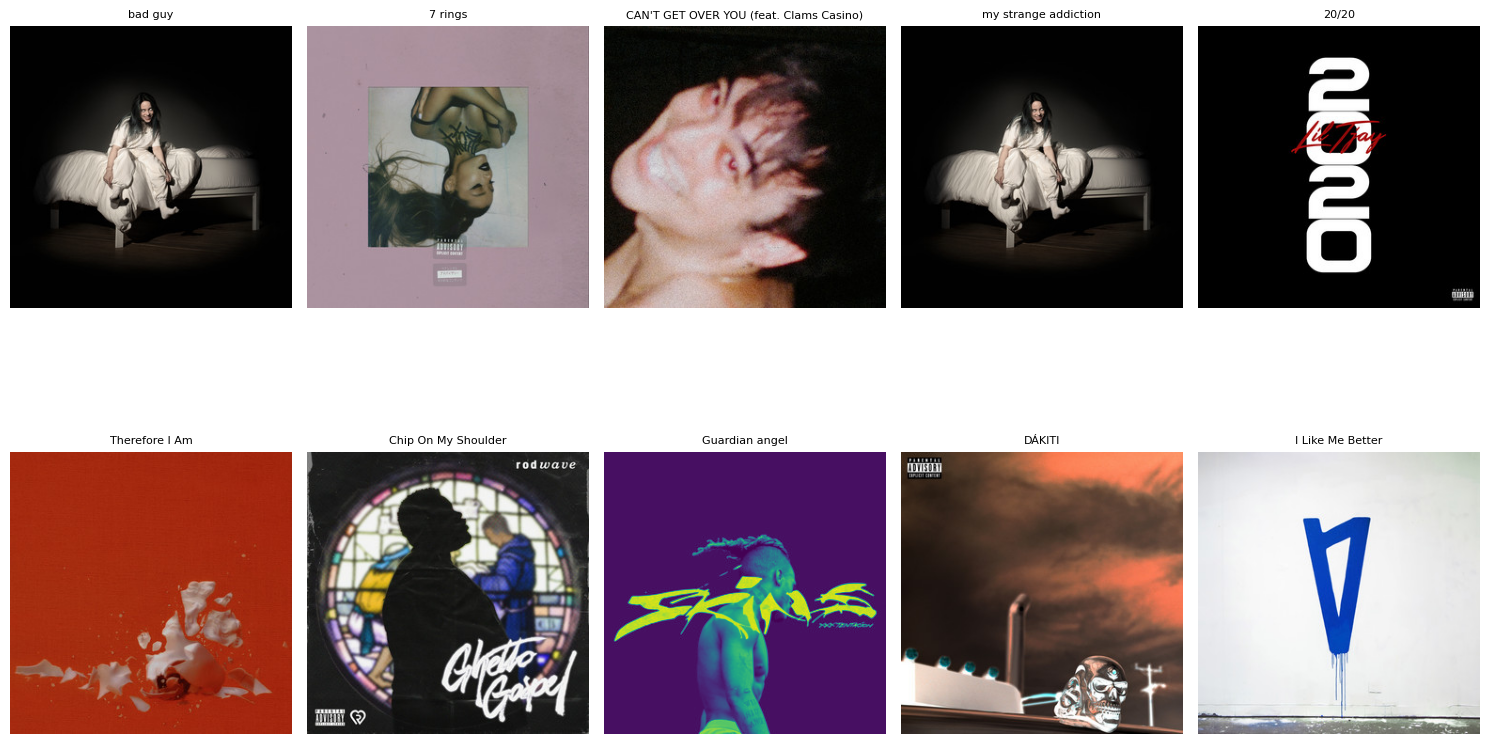

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

from spotify.recommendations import recommend_id, recommend_music

def visualize_songs(name, url):
    num_images = len(url)
    num_columns = 5

    # Calculate the number of rows needed for the subplot grid
    num_rows = (num_images + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

    for i, (song_name, img_url) in enumerate(zip(name, url)):
        ax = axes[i // num_columns, i % num_columns]

        # Read the image using scikit-image
        image = io.imread(img_url)

        ax.imshow(image)
        ax.set_title(song_name, fontsize=8)

        # Hide axis labels and ticks
        ax.axis('off')

    # Remove any empty subplots if there are more than needed
    for i in range(num_images, num_columns * num_rows):
        fig.delaxes(axes[i // num_columns, i % num_columns])

    # Adjust subplot layout
    plt.tight_layout()

    # Display the plot
    plt.show()


music_name = 'Billie Eilish - bad guy'

playlst_id = recommend_music(music_name, projection_v2, data)['id']
song_names, image_urls, artist, spotify_url = recommend_id(playlst_id)

visualize_songs(song_names, image_urls) 